
# Mini‑proyecto integrador de la estadística y matemática en Data Science

**Objetivo:**  
Aplicar, de forma sencilla y guiada, los conceptos de:
- Álgebra lineal (datos como matrices, productos)
- Estadística descriptiva (media, desviación, histogramas)
- Probabilidad (intuición de incertidumbre y ruido)
- Regresión lineal (modelo simple)

en un pequeño caso práctico de predicción.

---

## Escenario: predicción del precio de alquiler

Imagina que trabajas en una plataforma de alquileres y quieres un modelo muy sencillo que te ayude a **estimar el precio mensual** de un piso en función de:

- `metros` (tamaño del piso)
- `habitaciones`
- `centro` (1 si está cerca del centro, 0 si no)

En este mini‑proyecto vas a:

1. Generar un dataset sintético.
2. Explorar los datos con estadísticas y gráficos.
3. Construir una matriz de diseño `X` y un vector `y`.
4. Ajustar una regresión lineal mediante la fórmula matricial.
5. Evaluar el error y probar a predecir nuevos casos.


## 1. Importar librerías y fijar semilla

Empezamos importando las librerías estándar y fijando una **semilla** para que los resultados sean reproducibles.


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(2025)

np.set_printoptions(precision=3, suppress=True)
pd.set_option('display.precision', 3)

print("Librerías cargadas.")


Librerías cargadas.



## 2. Generar un dataset sintético de pisos

Vamos a crear un dataset inventado pero realista:

- `metros`: alrededor de 80 m² con bastante variación.
- `habitaciones`: dependerá de los metros (más grande ⇒ más habitaciones).
- `centro`: 1 si está en zona cara, 0 si no.
- `precio`: construido con una **fórmula base** + **ruido aleatorio**.

La idea es que `precio` dependa de:
- metros (más metros ⇒ más caro),
- habitaciones (más habitaciones ⇒ más caro),
- centro (vivir en el centro encarece mucho).


In [4]:

N = 400

metros = rng.normal(80, 25, size=N).clip(30, 160)
habitaciones = np.clip((metros / 30 + rng.normal(0, 0.7, size=N)).round().astype(int), 1, 6)
centro = rng.integers(0, 2, size=N)  # 0 o 1

precio = (
    15 * metros +       # 15 €/m2
    50 * habitaciones + # pequeño extra por habitación
    400 * centro +      # vivir en el centro encarece
    rng.normal(0, 200, size=N)  # ruido aleatorio
)

data = pd.DataFrame({
    "metros": metros,
    "habitaciones": habitaciones,
    "centro": centro,
    "precio": precio
})

data.head()


,metros,habitaciones,centro,precio
0,59.643,2,0,693.614
1,83.472,3,1,2097.788
2,102.902,3,0,1445.982
3,80.500,2,1,1646.611
4,48.996,1,1,1312.794



### Ejercicio 1 (exploración rápida)

1. Llama a `data.describe()` para ver un resumen numérico del dataset.  
2. Cuenta cuántos pisos hay en el centro (`centro == 1`) y cuántos no.  
3. Piensa: ¿son realistas estos rangos de precios y metros? ¿Qué cambiarías?


In [5]:

print("Resumen numérico:")
print(data.describe())

print("\nConteo de pisos según centro:")
print(data["centro"].value_counts())


Resumen numérico:
        metros  habitaciones   centro    precio
count  400.000       400.000  400.000   400.000
mean    82.894         2.775    0.507  1580.282
std     23.995         1.021    0.501   487.782
min     30.000         1.000    0.000   154.140
25%     66.565         2.000    0.000  1255.774
50%     82.976         3.000    1.000  1568.107
75%    100.235         3.000    1.000  1894.701
max    160.000         6.000    1.000  3097.650

Conteo de pisos según centro:
centro
1    203
0    197
Name: count, dtype: int64



## 3. Visualización básica

Vamos a visualizar la relación entre:
- `metros` y `precio`
- `habitaciones` y `precio`
- Cómo influye `centro` en el precio


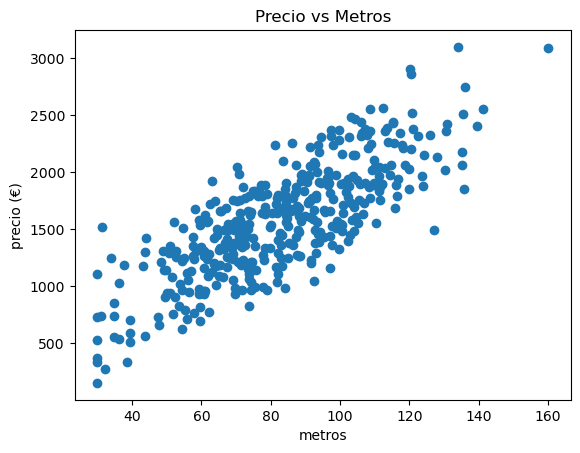

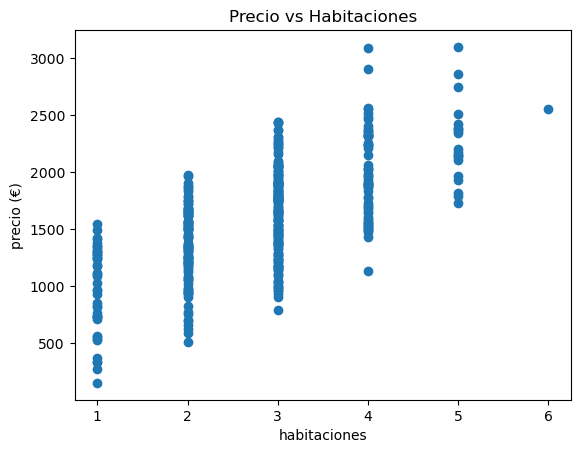

In [6]:

plt.figure()
plt.scatter(data["metros"], data["precio"])
plt.title("Precio vs Metros")
plt.xlabel("metros"); plt.ylabel("precio (€)")
plt.show()

plt.figure()
plt.scatter(data["habitaciones"], data["precio"])
plt.title("Precio vs Habitaciones")
plt.xlabel("habitaciones"); plt.ylabel("precio (€)")
plt.show()


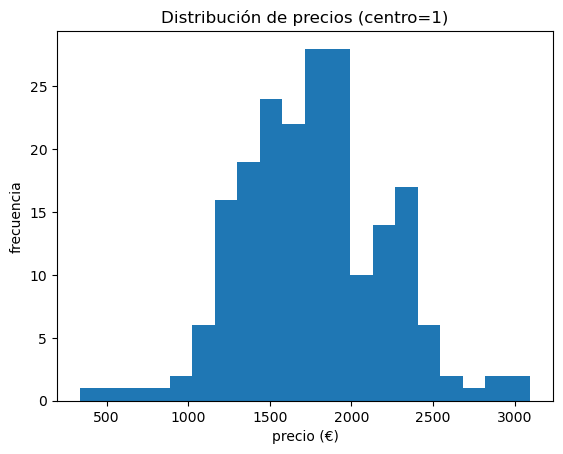

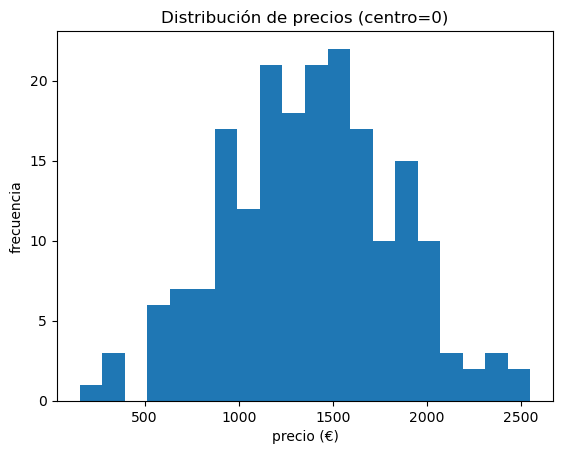

In [7]:

plt.figure()
plt.hist(data.loc[data["centro"] == 1, "precio"], bins=20)
plt.title("Distribución de precios (centro=1)")
plt.xlabel("precio (€)"); plt.ylabel("frecuencia")
plt.show()

plt.figure()
plt.hist(data.loc[data["centro"] == 0, "precio"], bins=20)
plt.title("Distribución de precios (centro=0)")
plt.xlabel("precio (€)"); plt.ylabel("frecuencia")
plt.show()



### Ejercicio 2 (interpretación)

1. Mira los gráficos anteriores:  
   - ¿Tienden los pisos más grandes a ser más caros?  
   - ¿Qué se observa con las habitaciones?  
   - ¿Hay diferencia visible entre precios en el centro y fuera del centro?
2. Escribe en texto libre 3 conclusiones sobre el dataset.

El tamaño influye en el precio: A mayor superficie, mayor precio, aunque no de manera estricta.

Número de habitaciones no es un predictor tan fuerte: No siempre más habitaciones significan mayor precio, la relación es más débil.

Ubicación importa: Los pisos en el centro son más caros que los de fuera del centro, indicando que la localización tiene un efecto claro en el valor.


## 4. Construir la matriz de diseño X y el vector y

Recordemos el punto de vista de **álgebra lineal**:

- Cada fila de `X` será un piso.
- Cada columna será una característica (feature): 1, metros, habitaciones, centro.
- El vector `y` será el precio.

Modelo lineal:

\[
\hat{y} = b + a_1 \cdot \text{metros} + a_2 \cdot \text{habitaciones} + a_3 \cdot \text{centro}
\]

En forma matricial:

\[
\hat{y} = X w
\]


In [8]:

X = np.c_[
    np.ones(len(data)),
    data["metros"].values,
    data["habitaciones"].values,
    data["centro"].values
]

y = data["precio"].values.reshape(-1, 1)

print("Forma de X:", X.shape)
print("Forma de y:", y.shape)


Forma de X: (400, 4)
Forma de y: (400, 1)



### Ejercicio 3

1. Muestra la primera fila de `data` con `data.iloc[0]`.  
2. Comprueba que coincide con la primera fila de `X` (1, metros, habitaciones, centro) y el primer valor de `y`.


In [11]:
print(data.iloc[0])

X = np.c_[
    np.ones(len(data)),
    data["metros"].values,
    data["habitaciones"].values,
    data["centro"].values
]

y = data["precio"].values.reshape(-1, 1)

print("Primera fila de X:", X[0])
print("Primer valor de y:", y[0])


metros           59.643
habitaciones      2.000
centro            0.000
precio          693.614
Name: 0, dtype: float64
Primera fila de X: [ 1.    59.643  2.     0.   ]
Primer valor de y: [693.614]



## 5. Ajustar el modelo con OLS (fórmula matricial)

Usamos la fórmula:

\[
w = (X^T X)^{-1} X^T y
\]


In [12]:

w = np.linalg.inv(X.T @ X) @ X.T @ y

b_hat, a1_hat, a2_hat, a3_hat = w.ravel()
print("Parámetros estimados:")
print(f"b (intercepto) ≈ {b_hat:.1f}")
print(f"a1 (metros)    ≈ {a1_hat:.1f}")
print(f"a2 (habitaciones) ≈ {a2_hat:.1f}")
print(f"a3 (centro)    ≈ {a3_hat:.1f}")

print("\nModelo estimado:")
print(f"precio ≈ {b_hat:.1f} + {a1_hat:.1f}*metros + {a2_hat:.1f}*habitaciones + {a3_hat:.1f}*centro")


Parámetros estimados:
b (intercepto) ≈ -29.6
a1 (metros)    ≈ 14.2
a2 (habitaciones) ≈ 77.3
a3 (centro)    ≈ 435.0

Modelo estimado:
precio ≈ -29.6 + 14.2*metros + 77.3*habitaciones + 435.0*centro



### Preguntas de interpretación

1. ¿Cuánto aumenta aproximadamente el precio por cada metro cuadrado extra?  
2. ¿Cuánto añade, de media, vivir en el centro (`centro = 1`)?  
3. ¿Te parecen razonables estos valores comparados con la regla con la que generamos los datos?



## 6. Evaluar el modelo: MSE y R²

Calculamos:

- **MSE** (Error Cuadrático Medio): promedio del error al cuadrado.
- **R²**: qué porcentaje de la variabilidad del precio explica nuestro modelo.


In [ ]:

y_hat = (X @ w).ravel()
y_true = y.ravel()

mse = np.mean((y_true - y_hat)**2)
ss_tot = np.sum((y_true - y_true.mean())**2)
ss_res = np.sum((y_true - y_hat)**2)
r2 = 1 - ss_res/ss_tot

print("MSE del modelo:", round(mse, 2))
print("R² aproximado:", round(r2, 3))



### Ejercicio 4

1. Interpreta el valor de R² en una frase dirigida a alguien no técnico.  
2. Si R² fuera muy bajo (por ejemplo 0.2), ¿qué podrías hacer para mejorar el modelo?



## 7. Probar predicciones con nuevos pisos

Creamos algunos ejemplos de pisos y les pedimos al modelo que estime su precio:

- Piso A: 70 m², 2 habitaciones, centro=0  
- Piso B: 90 m², 3 habitaciones, centro=1  
- Piso C: 50 m², 1 habitación, centro=0


In [ ]:

nuevos = np.array([
    [1, 70, 2, 0],
    [1, 90, 3, 1],
    [1, 50, 1, 0]
])

pred_nuevos = (nuevos @ w).ravel()

for i, precio_est in enumerate(pred_nuevos, start=1):
    print(f"Piso {i}: precio estimado ≈ {precio_est:.2f} €")



### Ejercicio 5

1. Añade 3 pisos inventados por ti (con diferentes metros, habitaciones y centro).  
2. Calcula sus precios estimados.  
3. Comenta si los resultados te parecen coherentes.

---

## Resumen

En este notebook has puesto en práctica:

- Representar datos en forma de **matriz X** y **vector y**.  
- Usar **estadística descriptiva** para entender un dataset.  
- Ajustar un modelo lineal con **álgebra matricial**.  
- Interpretar coeficientes, **MSE** y **R²**.  
- Hacer **predicciones** sobre nuevos casos.

Extras:
>   1. ¿Qué has aprendido sobre modelos lineales?  
>   2. ¿Qué limitaciones le ves a este modelo en un caso real?  
>   3. ¿Qué variables extra añadirías (por ejemplo: barrio, estado del piso, ascensor…)?


In [1]:
a = 21
b = 2
c = 3
print(a+b+c)

26
